# Summary of Kennicott Glacier Point Balance Work

## Tristan Amaral, August 31, 2020
## Modified by M Loso, 2021_11_22


### 1. Introduction

The Kennicott Glacier in Wrangell St. Elias National Park and Preserve presents a unique opportunity to examine ablation zone mass balance and dynamics of debris covered terminal ice. The Kennicott Glacier’s lower reaches can be easily accessed via foot from the nearby town of McCarthy, and by Alaska standards, the glacier has been well monitored since 2016, with a National Park Service (NPS) managed ablation stake mass balance program, six meteorological stations located on or near the glacier, and remarkably dense LiDAR coverage over the terminal region. Previous scientific studies on the Kennicott Glacier have investigated glacier-dammed lake outburst floods (Anderson et al., 2003; 2005; Armstrong and Anderson, 2020), subglacial water pressure and ice acceleration (Bartholomaus et al., 2008; Armstrong and Anderson, 2017), and geomorphology of debris-covered ice (Anderson et al., 2015; Buri et al., in prep). With the installation of an ablation stake mass balance network on the Kennicott Glacier in 2016, sufficient observation data now exist to complete a partial Kennicott Glacier mass balance analysis.  This is a timely endeavor, given the lack of existing mass balance research on Kennicott Glacier (with the exception of Loso et al., 2014), and the contribution that mass balance information may provide to the Kennicott Glacier Interpretation Plan. 

Here, I present preliminary work towards the goal of determining point balances at ablation stake locations on the lower Kennicott Glacier during the period 2016 to 2020. Using text and code, this document describes the input data sets, quality control steps, lapse rate calculations, and an example melt model at a single ablation stake for the Kennicott Glacier. All data files and code is stored on the Kennicott-Glacier-Sharing GitHub site. 


### 2. Input Data

Below I briefly describe each meteorological data set and its usage in the analysis. I only provide details on the period of data collection relative to the 2016 – 2020 period. Data sets and associated metadata are saved in the Raw_Climate_Records while formatted data (pickle dataframes and csv files) and associated metadata are found in the DATA folder on the GitHub. 

#### 2.1 Temperature Records

In [25]:
# Set up Console for data loading
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from matplotlib.lines import Line2D
from matplotlib import cm
from scipy import stats
%matplotlib inline
plt.style.use('ggplot')

# data folder (commented is his original)
#raw_data = r'C:\Users\tamaral\Documents\GIP-2020\Kennicott\PROJECT\Kennicott-Glacier-Sharing\Raw_Climate_Records'
#format_data = r'C:\Users\tamaral\Documents\GIP-2020\Kennicott\PROJECT\Kennicott-Glacier-Sharing\DATA'

raw_data = r'/mnt/c/Users/MGLoso/Documents/software/KennGlacMet/Raw_Climate_Records'
format_data = r'/mnt/c/Users/MGLoso/Documents/software/KennGlacMet/DATA'



 1.	United States Geological Survey (USGS) Kennicott River gage station:
A USGS gage site records water discharge and stage on the Kennicott River in the town of McCarthy, less than 2 miles from the outlet at the Kennicott Glacier. This site contains air temperature data recorded at 15-minute intervals. The data are continuous from 2016 to 2020, with the exception of an 7 month data gap between  October 10, 2018 and May 8, 2019. 

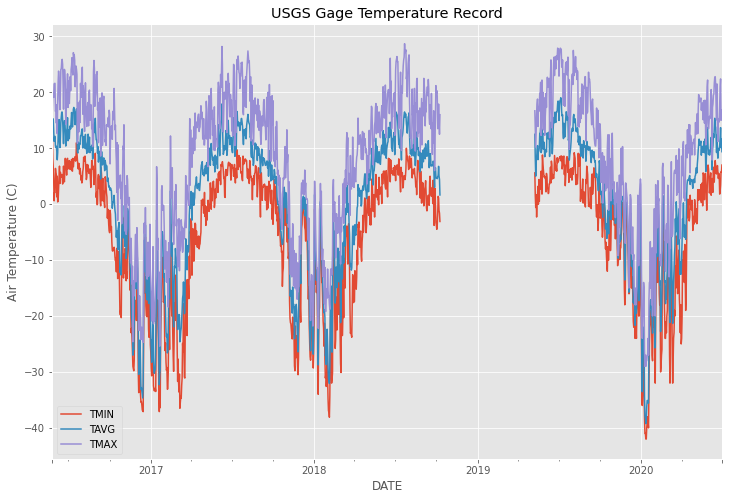

In [26]:
#----------------
# USGS GAGE DATA
#----------------

# ---compile metadata 
# elevation relative to NGVD29, lat/lon reference to NAD27
gage_meta = pd.DataFrame(data=[[408.83,'61.4332895824','-142.9446852347']],
                         columns=['el','lat','lon']) # el in m, NAVD 88
# csv of 15 minute air temperatures (C) from USGS Kenn gage
gage_path = os.path.join(raw_data,'USGS_15209700_airtemp.csv')

# --- read in with pandas CAUTION: 122k lines long...very big!
gageraw = pd.read_csv(gage_path,usecols=[1,2],header=14) #, parse_dates=['Timestamp (UTC-09:00)'])
gageraw.columns = ['DATE','Temp']

# --- shorten into TMIN, TAVG, TMAX
gageraw.index = pd.to_datetime(gageraw.DATE)
gage = gageraw.resample('D')['Temp'].agg(['min','mean','max']) # resample by day
gage.columns = ['TMIN','TAVG','TMAX'] # rename 
gage.index = gage.index.tz_localize(tz='US/Alaska')

# --- plot
fig,ax = plt.subplots(figsize=(12,8))
gage.plot(ax=ax,title='USGS Gage Temperature Record')
ax.set_ylabel('Air Temperature (C)')
plt.show()

2.	 National Weather Service Cooperative Observation Site (referred to as NWS coop)
A cooperative citizen observer conducted daily air temperature, precipitation, and weather observations from January 1, 2016 to December 31, 2017. Daily air temperature measures include daily maximum, mean, and average temperatures. This data set is not used in the lapse rate calculation due to its spatial correlation with the USGS temperature record, and the lack of recorded temperature data more recent than 2017. 

In [27]:
def ftm(value, reverse=False):
    "function to convert between m and ft. Default is ft to m, but can handle reverse"
    
    new_val = value * (12 * 2.54 / 100) # ft to m
    
    if reverse:
        new_val = value * (100 / (12 * 2.54)) #m to ft
        
    return new_val

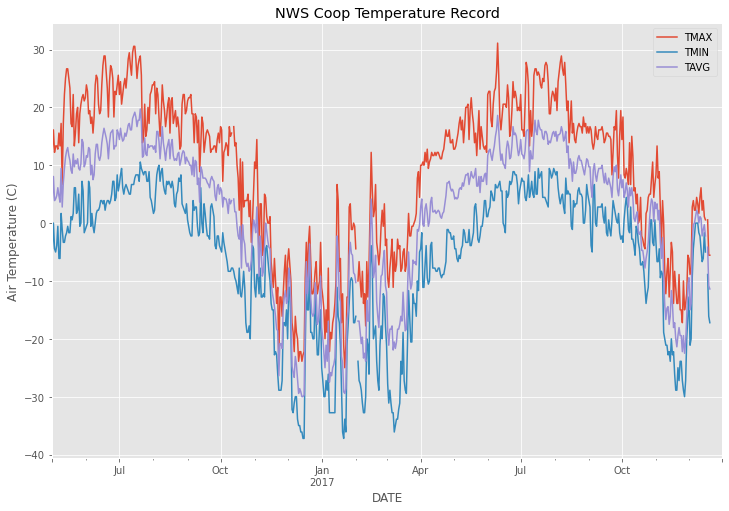

In [28]:
#--------------------
# NWS COOP McCarthy
#--------------------

# --- compile metadata
coop_meta = pd.DataFrame(data=[[1250,61.4180,-142.9961,505757]],
                         columns = ['el','lat','lon','ID']) # el in ft
# convert el to m
coop_meta.el = ftm(coop_meta.el)
# text file of daily weather obs from McCarthy town
coop_path = os.path.join(raw_data,'NWS_coop_505757_csv.txt')

# --- read in with pandas
coop = pd.read_csv(coop_path,header=2,skip_blank_lines=False,
                      parse_dates = ['Date'])

coop.rename({'Date':'DATE',' MaxTemperature':'TMAX',
                        ' MinTemperature':'TMIN',' AvgTemperature':'TAVG'},
                         axis='columns',inplace=True,errors='raise')
# remove 'M', covert dtypes to float
coop = coop.replace({' M':np.nan,' T':np.nan}) # replace flag values with NaN
coop = coop.set_index('DATE').tz_localize('US/Alaska') # set date as index and localize
coop = coop.astype(float,errors='raise')
# convert to C
coop.loc[:,['TMAX','TAVG','TMIN']] = (coop.loc[:,['TMAX','TAVG','TMIN']]-32) * (5/9)
coop = coop.drop(columns=[' Precipitation',' Snowfall',' SnowDepth']) # remove non temp columns

# --- plot
fig,ax = plt.subplots(figsize=(12,8))
coop.plot(ax=ax,title='NWS Coop Temperature Record')
ax.set_ylabel('Air Temperature (C)')
plt.show()

3.	May Creek Bureau of Land Management (BLM)/SNOTEL site
There are two meteorological stations located at the May Creek site east of McCarthy and the Kennicott Glacier. A SNOTEL site managed by the Natural Resources Conservation Service provides consistent records of snowfall, snow depth, and snow water equivalent (SWE) at hourly intervals from 2016 to 2020. Although the SNOTEL site also records air temperature, these data are not publicly available due to issues with sensor calibration and measurement bias. The BLM weather station records hourly measurements of general meteorological variables, including air temperature, relative humidity, wind speed and direction, and rainfall. Since the May Creek stations are not located right near or in the Kennicott Glacier valley, the BLM air temperature was not directly used in the lapse rate calculation, but was employed in the gap-filling regression for the USGS temperature record.

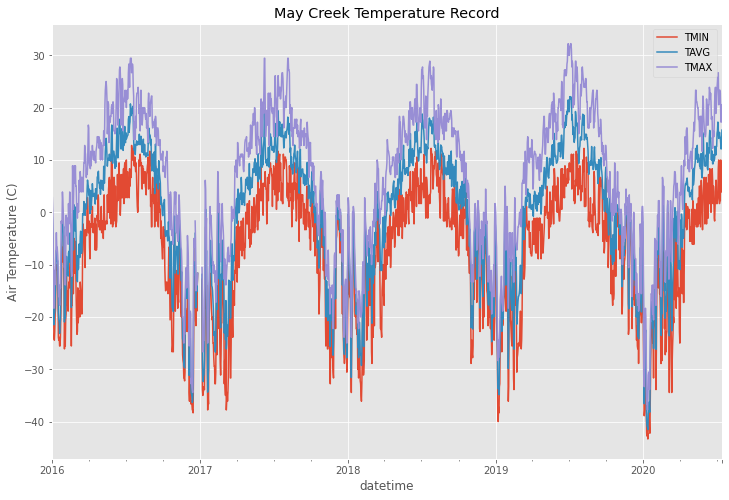

In [29]:
#-----------
# MAY CREEK
#-----------

# --- Compile station metadata
may_meta = pd.DataFrame(data=[[487.7,61.6028,-142.5844,'USR0000AMAY']],
                          columns=['el','lat','lon','ID']) # el in m
# --- read in with pandas
may_path = os.path.join(raw_data,'MayCreekRAWS_19900501-20200713.csv')
may_full = pd.read_csv(may_path, header=1,parse_dates={'datetime':[0,1]}, # takes ~30 seconds to read in...very large file!
                       index_col='datetime')
# --- subset and convert
may_full = may_full.loc[:,'Air Temperature (F)'] # just grab temperature column
# subset years
may_full.index = pd.to_datetime(may_full.index).tz_localize('Etc/GMT-9').tz_convert('US/Alaska')
may_full.columns = 'T2'
start = pd.Timestamp('2016-01-01 00:00:00',tz='US/Alaska')
end = may_full.index[-1]
mayseries = may_full.loc[start:end] # just temperature series
# replace bad values
mayseries.replace(-9999,np.nan,inplace=True)
# convert to celcius
mayseries = (mayseries - 32) * (5/9)

# --- resample to daily
may = mayseries.resample('D').agg(['min','mean','max']) 
may.columns = ['TMIN','TAVG','TMAX']

# --- plot
fig,ax = plt.subplots(figsize=(12,8))
may.plot(ax=ax,title='May Creek Temperature Record')
ax.set_ylabel('Air Temperature (C)')
plt.show()


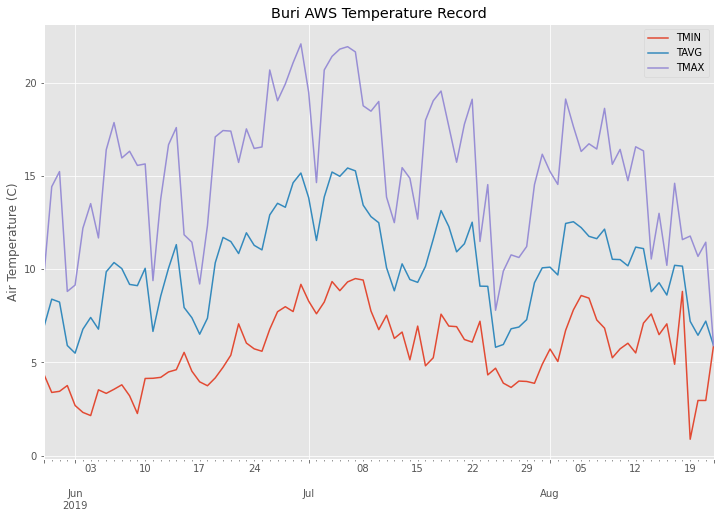

In [30]:
#------------
# BURI AWS
#------------

# --- complile metadata
buri_meta = pd.DataFrame(data=[[606,61.4841,-142.9283]],
                         columns=['el','lat','lon']) # el in m, ll in deg

# txt file of hourly 2-m air temp from Pascal Buri in 2019
buri_path = os.path.join(raw_data,'BURI_AWS_2019.txt') # dates in AKDT
      
# --- read with pandas
buri = pd.read_table(buri_path,parse_dates=['Date'])
buri.columns  # view/rename headers
buri.rename({'T_a2m':'T2'},axis='columns',inplace=True) # rename temperature column
# some dates in middle are messed up, so make clean date column
date_index = pd.date_range(start=buri.iloc[0,0],end=buri.iloc[-1,0],
                           freq='H')
buri.index = date_index.tz_localize(tz='US/Alaska') # make new date column the index

# ---- New df with daily tmax,tmin,tavg data
buridd = buri.resample('D')['T2'].agg(['min','mean','max']) # resample by day and grab max, min, and avg
buridd.columns = ['TMIN','TAVG','TMAX'] # rename columns

# --- plot
fig,ax = plt.subplots(figsize=(12,8))
buridd.plot(ax=ax,title='Buri AWS Temperature Record')
ax.set_ylabel('Air Temperature (C)')
plt.show()

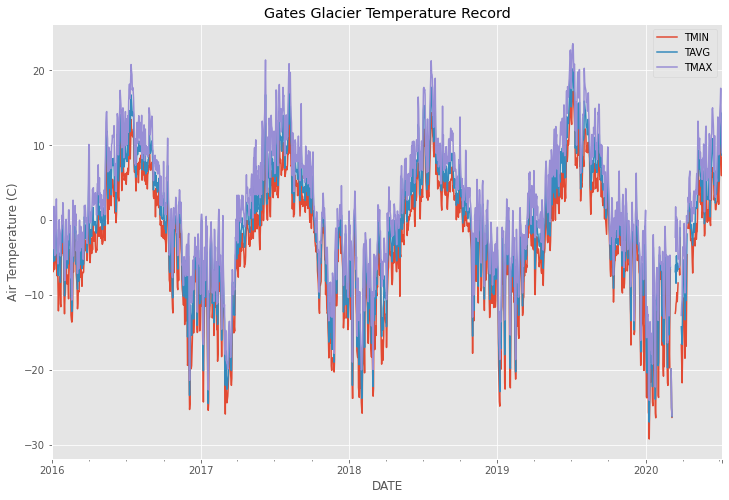

In [31]:
# ----------
# GATES GL
# ----------

# --- Compile station metadata
gates_meta = pd.DataFrame(data=[[1237.5,61.6028,-143.0131,'USR0000AGAT']],
                          columns=['el','lat','lon','ID']) # el in m
# --- Record 1
# load csv of full record downloaded from NPS IRMA site
#  https://irma.nps.gov/DataStore/Reference/Profile/2266884
gates_path = os.path.join(raw_data, 'WC_G_GGLA2.csv')
# contains full record, only take useful cols
#cols = [1,2,3,8,9,20,21] # rain, avgT, sd and quality parameters for each
gates_full = pd.read_csv(gates_path,skip_blank_lines=False,
                         header=14,parse_dates=['timestamp_utc'])
# --- parse down to 2016 - 2019
# convert index to AK time
gates_full.loc[:,'DATE'] = gates_full['timestamp_utc'].dt.tz_localize('utc').dt.tz_convert('US/Alaska')
gates_full = gates_full.set_index(['DATE'])
# subset data into new df 
start = pd.Timestamp('2016-01-01 00:00:00',tz='US/Alaska')
end = gates_full.index[-1]
gates_sub = gates_full.loc[start:end,['atf','sdi']]  # order is date, temp, sd
gates_sub.columns = ['T2','SDI']  # rename for concat         

# ---- Record 2
# load csv of ~last year data from Gates Gl (not finalized)
# accessed via https://download.synopticdata.com/#a/GGLA2
gates2019_path = os.path.join(raw_data,'GGLA2.2020-07-07.csv')
# read in
gates2019 = pd.read_csv(gates2019_path, header=10, skiprows=[11],
                        parse_dates=['Date_Time'])
# convert time to AK then coerce to hourly timestamps
gates2019.loc[:,'DATE'] = gates2019['Date_Time'].dt.tz_convert('US/Alaska')
gates2019.loc[:,'DATE'] = gates2019.DATE - pd.Timedelta(33,'minutes') # on the hour
gates2019 = gates2019.set_index(['DATE'])
# subset for concatenation
start2 = end + pd.Timedelta(1,'hour') # don't duplicate values from the QC-ed data in gates_sub
gates2019_sub = gates2019.loc[start2:,['air_temp_set_1','snow_depth_set_1']]
gates2019_sub.columns = ['T2','SDI'] # rename for concat

# --- Concatenate dataframes to combine record
gates = pd.concat([gates_sub,gates2019_sub]) # should be no duplicates but can check
# gates[gates.index.duplicated(keep=False)]
# convert F to C
gates.loc[:,'T2'] = (gates.T2 - 32) * (5/9)

# --- Resample to daily
gatesdd = gates.resample('D')['T2'].agg(['min','mean','max']) # resample by day and grab max, min, and avg
gatesdd.columns = ['TMIN','TAVG','TMAX'] # rename columns

# --- plot
fig,ax = plt.subplots(figsize=(12,8))
gatesdd.plot(ax=ax,title='Gates Glacier Temperature Record')
ax.set_ylabel('Air Temperature (C)')
plt.show()

In [32]:
#-------------------
# SAVE DATAFRAMES
#-------------------
#---- Combine into one temperature df
combine = [gatesdd,
           may,
           buridd,
           gage,
           coop]

names = ['gates','may','buri','usgs','coop'] # become keys in the concat df
t = pd.concat(combine,axis=1,keys=names) # put into single df

# ---- combine metadata into one df
metadata = [gates_meta,may_meta,buri_meta,gage_meta,coop_meta]
names = ['gates','may','buri','usgs','coop'] # use same keys to access
meta = pd.concat(metadata,axis=0,keys=names) # df of dataframes

# --- save dataframes using pandas + pickle
# paths
meta_path = os.path.join(format_data,'temperature_meta.pickle')
temp_path = os.path.join(format_data,'daily_temperature_data.pickle')

# --- pickle
meta.to_pickle(meta_path)
t.to_pickle(temp_path)
# --- csv
meta.to_csv(os.path.join(format_data,'temperature_meta.csv'))
t.to_csv(os.path.join(format_data,'daily_temperature_data.csv'))


/tmp/ipykernel_12069/574046735.py:41: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(.1)


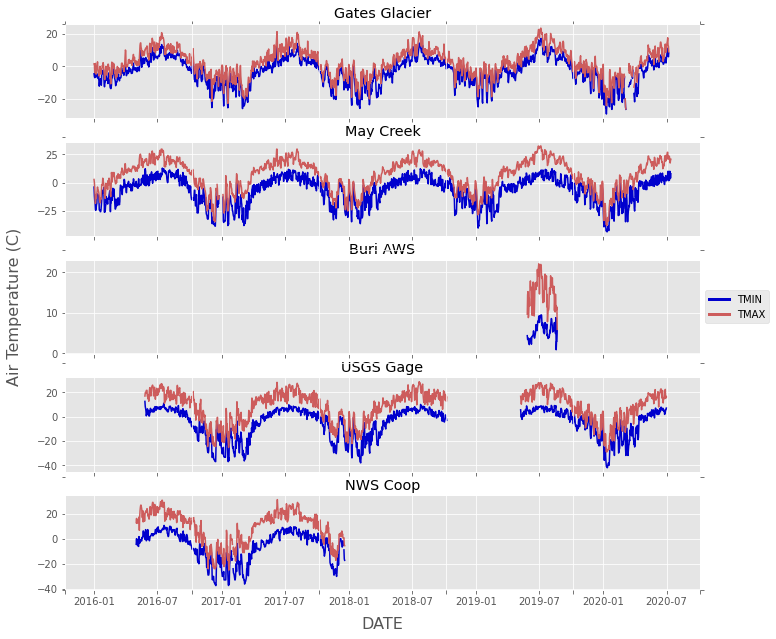

In [33]:
# --- plotting function 
def timesubplots(df):
    """Takes in dataframe with varying number of keys and plots each 
    temperature variable for each station (key). Assumes indexes are dates."""
    
    pd.plotting.register_matplotlib_converters()
    # get df dimensions and key names
    sites,vals = [],[]
    for key in df.keys():
        sites.append(key[0])
        vals.append(key[1])
    sites = pd.Series(sites).unique()
    vals = pd.Series(vals)
    vals = vals[vals!='TAVG'].unique()
    names = {'gates':'Gates Glacier','may':'May Creek','buri':'Buri AWS',
            'usgs': 'USGS Gage','coop': 'NWS Coop'}
    
    # plotting parameters
    fig,axs = plt.subplots(len(sites),1,sharex=True,figsize=(11,9))
    colors = ['mediumblue','indianred']
    
    # loop plotting
    for site,ax in zip(sites,axs): # for each subplot
        ax.set_title(names[site])
        for c,t in zip(colors,vals): # for each temp parameter
            ax.plot(df[site].index,df[site][t],color=c)

    # make labels
    ax = fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    ax.set_xlabel('DATE', labelpad=10,size=16) # Use argument `labelpad` to move label downwards.
    ax.set_ylabel('Air Temperature (C)', labelpad=20,size=16)
    
    # legend
    lines = [Line2D([0],[0],color=colors[0],lw=3),
             Line2D([0],[0],color=colors[1],lw=3)]
    ax.legend(lines,['TMIN','TMAX'],loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.grid(True)
    plt.tight_layout(.1)
    plt.show()
    
# ---  Plot five met records
timesubplots(t)

#### 2.2 Precipitation Records

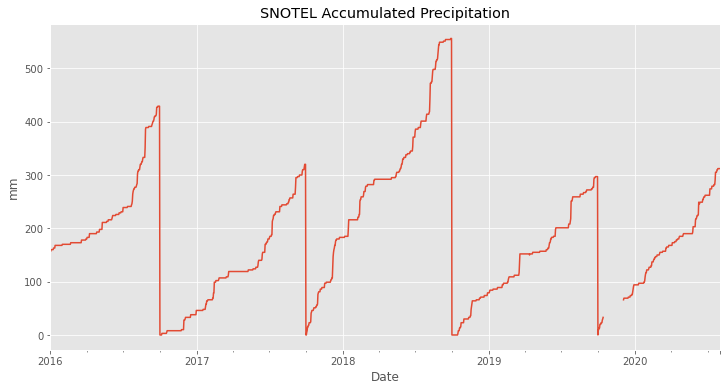

In [34]:
# ---- SNOTEL - Daily (Start of day) values 
snotel_path = os.path.join(raw_data,'SNOTEL_1096_MayCreek.txt')
# read in with pandas
snotel = pd.read_csv(snotel_path,header=56,parse_dates=True,index_col='Date')
# rename cols, units= mm, mm, cm, mm
# columns are accumulated precip per water year, precipitation increment, snow depth, snow water equivalent
snotel.columns = ['Precip_acc','Precip_inc','SDS','SWES'] 
# remove suspect data
snotel['SDS'] = snotel['SDS'].where(snotel.SDS < 100) # remove anamalously high snow depth value 

# Plot up accumulated precip record
fig,ax = plt.subplots(figsize=(12,6))
snotel.Precip_acc.plot(ax=ax)
ax.set_ylabel('mm')
ax.set_title('SNOTEL Accumulated Precipitation')
plt.show()

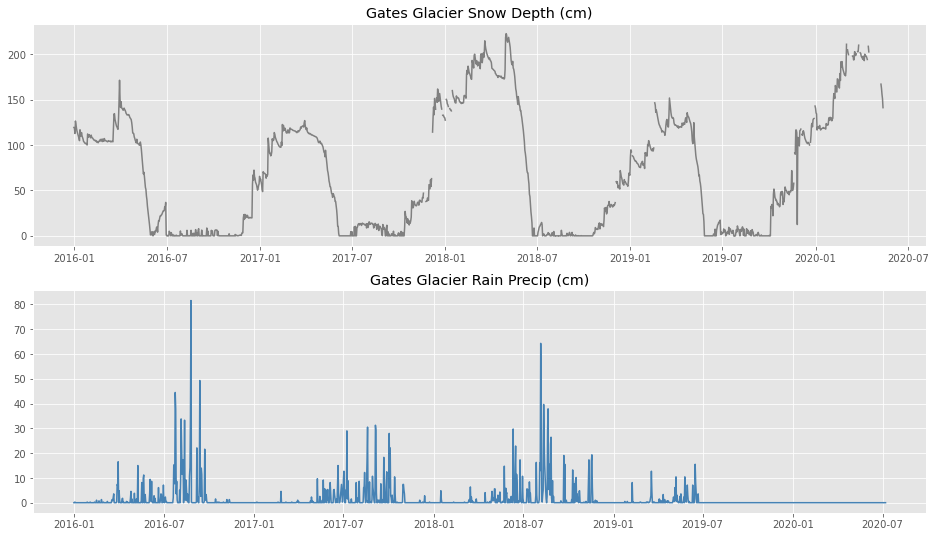

In [35]:
# NPS IRMA gates QAQC-ed data through 2019
gates_path = os.path.join(raw_data,'WC_G_GGLA2.csv')
# read with pandas
gates_full = pd.read_csv(gates_path,skip_blank_lines=False,header=14,
                    parse_dates=['timestamp_utc'],index_col=['timestamp_utc'])
# subset out precip columns
gates_full.index = gates_full.index.tz_localize('utc').tz_convert('US/Alaska').rename('DATE')
start = pd.Timestamp('2016-01-01 00:00:00-0800',tz='US/Alaska')
end = gates_full.index[-1]
gates_irma = gates_full.loc[slice(start,end),['sdi','rnin']]
gates_irma.columns = ['SD','RN'] # rename columns to match

# load csv of ~last year data from Gates Gl (not finalized)
# accessed via https://download.synopticdata.com/#a/GGLA2
gates2019_path = os.path.join(raw_data,'GGLA2.2020-07-07.csv')
# read in
gates2019 = pd.read_csv(gates2019_path, header=10, skiprows=[11],
                        parse_dates=['Date_Time'],index_col=['Date_Time'])
# convert time to AK then coerce to hourly timestamps
gates2019.index = (gates2019.index - pd.Timedelta(33,'minutes')).tz_convert('US/ALASKA').rename('DATE') 
# subset for concatenation
start2 = end + pd.Timedelta(1,'hour') # don't duplicate values from the QC-ed data in gates_sub
gates2019_sub = pd.DataFrame(gates2019.loc[start2:,'snow_depth_set_1'])
gates2019_sub.columns = ['SD'] # rename for concat

# --- Concatenate dataframes to combine record
gates_precip = pd.concat([gates_irma,gates2019_sub]) 
# remove bad values over 100
gates_precip['SD'] = gates_precip['SD'].where(gates_precip['SD'] < 100)

# convert values to metric
gates_precip = gates_precip * 2.54 # convert inches to cm
gates_precip['RN'] = gates_precip.loc[:,'RN'] * 10 # cm to mm

# resample to daily: mean for hourly SD and sum for hourly rain accum.
gatesdd_precip = gates_precip.resample('D').agg({'SD':'first','RN':'sum'})


#---- plot time series
pd.plotting.register_matplotlib_converters() # for some reason this needs to be run again
fig,[ax1,ax2] = plt.subplots(2,1,figsize=(16,9))
#  plot snow
ax1.plot(gatesdd_precip.index,gatesdd_precip.SD,color='gray')
ax1.set_title('Gates Glacier Snow Depth (cm)')
# plot rain
ax2.plot(gatesdd_precip.index,gatesdd_precip.RN,color='steelblue')
ax2.set_title('Gates Glacier Rain Precip (cm)')

plt.show()

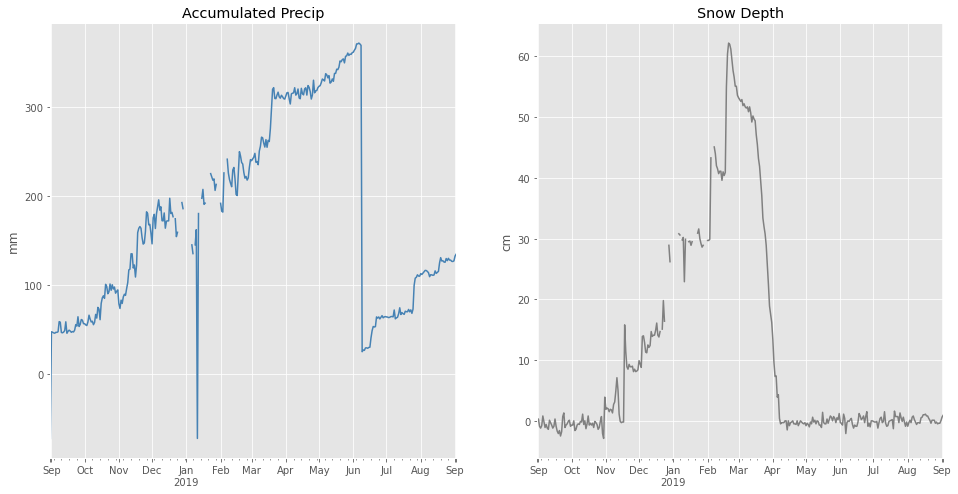

In [36]:
# ---- Chinese AWS lower on Kennicott ~675 m and off-glacier. Upper is 2185 m but fell down..
# get paths
dat_files = [f for f in os.listdir(raw_data) if f.endswith('.dat')]
lowerpath = os.path.join(raw_data,dat_files[0])
upperpath = os.path.join(raw_data,dat_files[1])
# read in lower chinese station
caws_raw = pd.read_csv(lowerpath,header=0,skiprows=[0,2,3],parse_dates=True,
                    index_col='TIMESTAMP')
# read in metadata header to get units of precip cols
with open(lowerpath,newline='') as f:
    head = [next(f) for x in range(4)]
# look up units for 'RainSnow'
names = head[1].split(',')
units = head[2].split(',')
rsun = units[names.index('"RainSnow"')] # units are mm
    
# explore
caws_raw = caws_raw.astype(dtype={'Snow_depth_Avg':float})
# resample to daily to match other precip records
caws = caws_raw.resample('D').agg({'Snow_depth_Avg':'first','RainSnow':'first'})  
caws = caws.loc[:,['Snow_depth_Avg','RainSnow']] # just get precip
caws.columns = ['SD','RS'] # rename
# coerce closer to actual values
corr = 176.4 # cm; correction height for snow depth sensor
caws['SD'] = caws['SD'] + corr # try to get non-snow values back near 0
# make new precip increment columns
caws['Precip_inc'] = caws.RS.diff() # find row differences
caws.Precip_inc.loc[caws.Precip_inc < 0] = np.nan

# visualize snow and precip records
fig,[ax1,ax2]= plt.subplots(1,2,figsize=(16,8))
caws.RS.plot(ax=ax1,title='Accumulated Precip',color='steelblue')
ax1.set_ylabel('mm'),ax1.set_xlabel('')
caws.SD.plot(ax=ax2,title='Snow Depth',color='gray')
ax2.set_ylabel('cm'),ax2.set_xlabel('')
plt.show()

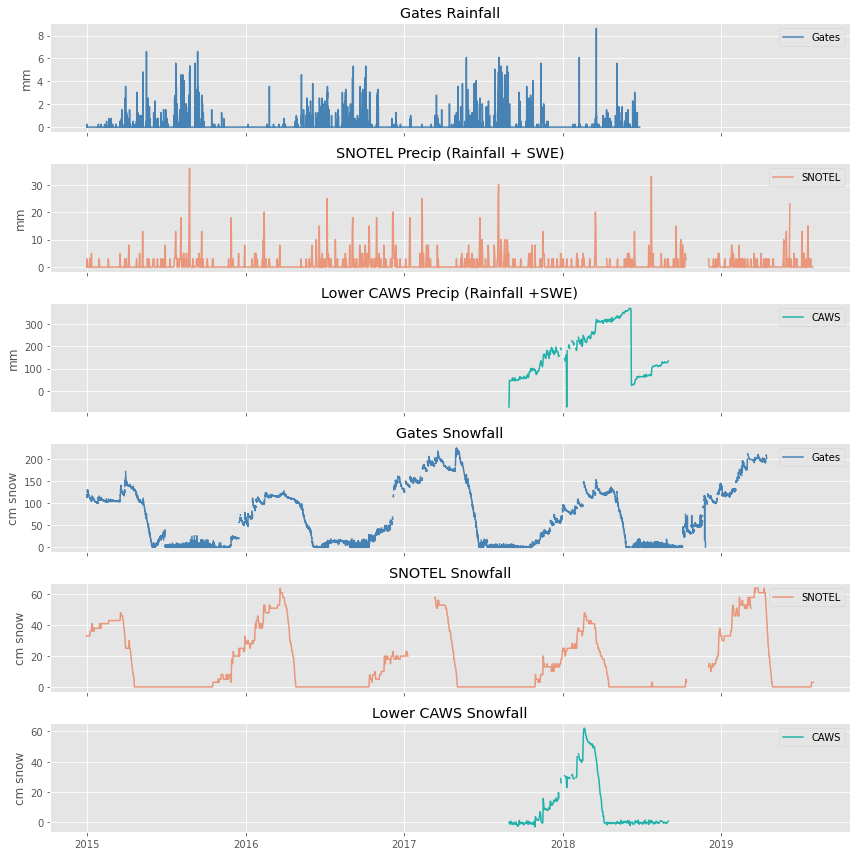

In [37]:
# ---- Plot suitable precip data (non-snow) on one plot
# gates and SNOTEL
fig,[ax1,ax2,ax3,ax4,ax5,ax6] = plt.subplots(6,1,sharex=True,figsize=(12,12))
pd.plotting.register_matplotlib_converters() # for some reason this needs to be run again
g,s,c = 'steelblue','darksalmon','lightseagreen'
# precip plots
ax1.set_title('Gates Rainfall')
ax1.plot(gates_precip.index,gates_precip.RN,label='Gates',color=g)
ax1.set_ylabel('mm')
ax1.legend()
ax2.set_title('SNOTEL Precip (Rainfall + SWE)')
ax2.plot(snotel.index,snotel.Precip_inc,label='SNOTEL',color=s)
ax2.set_ylabel('mm')
ax2.legend()
ax3.set_title('Lower CAWS Precip (Rainfall +SWE)')
ax3.plot(caws.index,caws.RS,label='CAWS',color=c)
ax3.set_ylabel('mm')
ax3.legend()

# snowfall
ax4.set_title('Gates Snowfall')
ax4.plot(gates_precip.index,gates_precip.SD,label='Gates',color=g)
ax4.set_ylabel('cm snow')
ax4.legend()
ax5.set_title('SNOTEL Snowfall')
ax5.plot(snotel.index,snotel.SDS,label='SNOTEL',color=s)
ax5.set_ylabel('cm snow')
ax5.legend()
ax6.set_title('Lower CAWS Snowfall')
ax6.plot(caws.index,caws.SD,label='CAWS',color=c)
ax6.set_ylabel('cm snow')
ax6.legend()

fig.tight_layout()
plt.show()


### 3. Analysis

#### 3.1 Temperature Record Examinations

In [38]:
# --- Load Data
meta = pd.read_pickle(os.path.join(format_data,'temperature_meta.pickle'))
dd = pd.read_pickle(os.path.join(format_data,'daily_temperature_data.pickle'))
# dd has tmin, tavg, tmax for gates, may, buri, usgs, coop

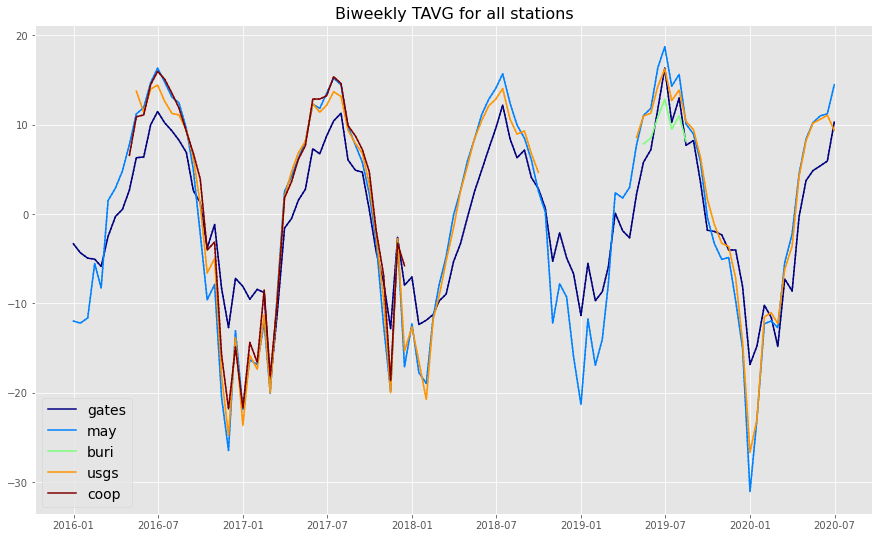

In [39]:
# 1. --- Bi-weekly averaged temperature plot
# resample to bi-weekly averages that are closed to the right: i.e. values for 1-15th of month are labelled as 15th.
bw = dd.resample('SM').mean() 
# plot figure
fig, ax = plt.subplots(figsize=(15,9))
ax.set_title('Biweekly TAVG for all stations', fontsize=16)
# iterators
keys = ['gates','may','buri','usgs','coop']
colors = [cm.jet(x) for x in np.linspace(0,1,5)]

for key,c in zip(keys,colors):
    ax.plot(bw[key].TAVG,label=key,color=c)
    ax.plot(bw[key].TAVG,color=c,linestyle='dotted')
ax.legend(fontsize=14)
plt.show()

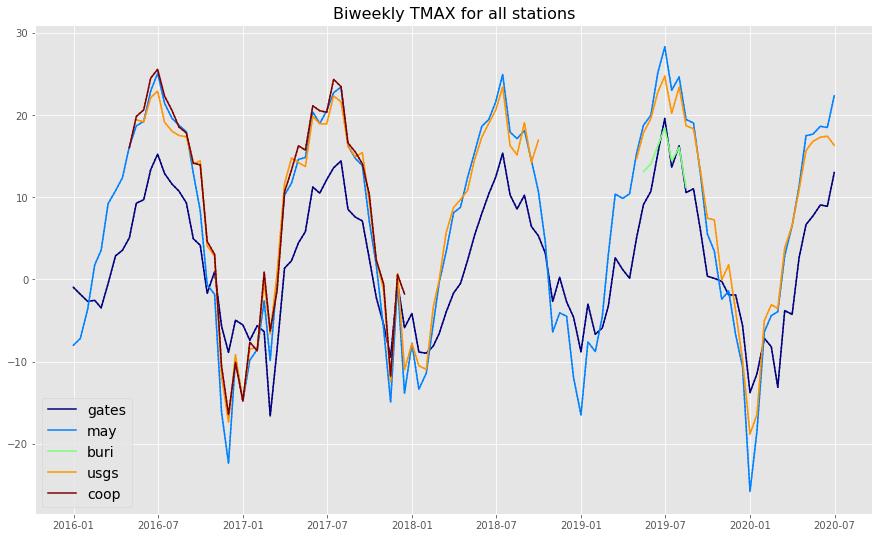

In [40]:
# 2. TMAX, TMIN for Bi-weekly average temperatures
# plot figure
fig, ax = plt.subplots(figsize=(15,9))
ax.set_title('Biweekly TMAX for all stations', fontsize=16)
# iterators
keys = ['gates','may','buri','usgs','coop']
colors = [cm.jet(x) for x in np.linspace(0,1,5)]

for key,c in zip(keys,colors):
    ax.plot(bw[key].TMAX,label=key,color=c)
    ax.plot(bw[key].TMAX,color=c,linestyle='dotted')
ax.legend(fontsize=14)
plt.show()

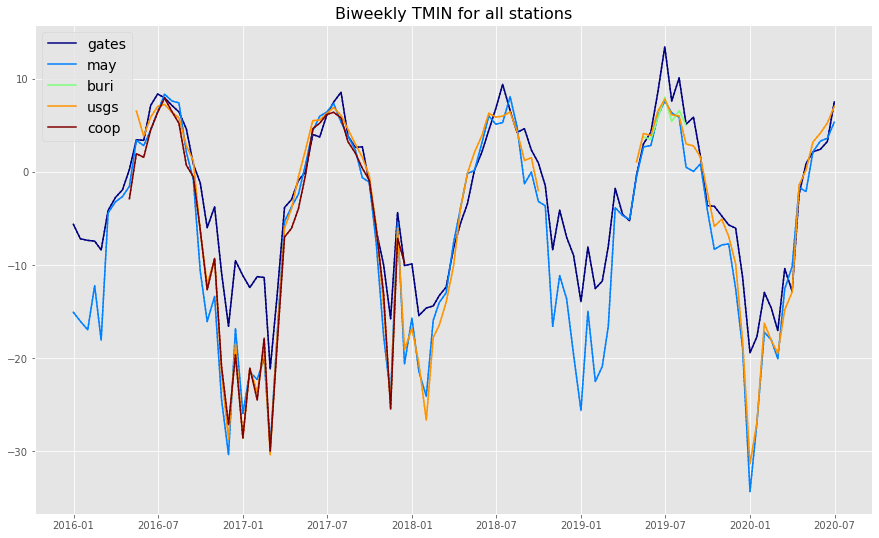

In [41]:
# 3. TMIN for Bi-weekly average temperatures
# plot figure
fig, ax = plt.subplots(figsize=(15,9))
ax.set_title('Biweekly TMIN for all stations', fontsize=16)
# iterators
keys = ['gates','may','buri','usgs','coop']
colors = [cm.jet(x) for x in np.linspace(0,1,5)]

for key,c in zip(keys,colors):
    ax.plot(bw[key].TMIN,label=key,color=c)
    ax.plot(bw[key].TMIN,color=c,linestyle='dotted')
ax.legend(fontsize=14)
plt.show()

In [42]:
#--- Seasonal plotting

# resample to different intervals
td = dd.resample('3D').mean() # three day averages
ww = dd.resample('W').mean() # weekly, closed to right (end of week)
bw = dd.resample('SM').mean() # semi-monthly
mm = dd.resample('M').mean() # monthly

# construct new custom AK summer index
def AK_ix(df):
    """ constructs new index for alaska summer that goes from
    May 1 to September 30. """
    
    seasons = {'summer': [4,5,6,7,8,9], # May - September
               'winter': [1,2,3,10,11,12]}
    months = {num:sea for sea in seasons.keys()
                            for num in seasons[sea]}
    # name winter according to year which it starts
    sea = pd.Series(df.index.month).map(months)+' ' + df.index.year.astype(str)
    # move winter years back
    for date,lab,i in zip(df.index.get_level_values(0),sea,np.arange(len(sea))):
        if date.month < 4: # subtract one from year..
            new = lab.split()[0]+ ' ' + str(int(lab.split()[1])-1)
            sea.iloc[i] = new
    # put back into dataframe
    seaidx = pd.Index(sea,name='SEASON')
    df = df.set_index(seaidx,append=True)
    
    return df

In [43]:
def summer_plots(df):
    """ Plotting function for different temperature resampling intervals."""
    # slice into summers 
    years = ['2016','2017','2018','2019','2020']
    for year in years:
        
        key = 'summer '+ year
        # subset out one season of data
        summer = df.xs(key=key,level='SEASON').unstack().unstack(level=1)
        
        # reshape and rename for plotting
        summer.index.set_names(['SITE','DATE'],inplace=True)
        
        # plot all variables
        fig,axs = plt.subplots(1,3,sharey=True,figsize=(14,8))
        fig.suptitle(key,fontsize=18)
        fig.subplots_adjust(top=0.88)
        
        vars = ['TMIN','TMAX','TAVG']
        plt.xticks(rotation='horizontal')
        for var,ax in zip(vars,axs.flatten()):
            summer.reset_index().pivot(index='DATE',columns='SITE',values=var).plot(
                ax=ax,title=var,linewidth=3)
            #ax.xaxis.set_major_locator(mdates.MonthLocator())
            #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # just put month abbr
            ax.set_xlabel('')
            
        # common labels
        fig.add_subplot(111, frame_on=False)
        plt.tick_params(labelcolor="none", bottom=False, left=False)
        plt.ylabel('Temperature (C)',fontsize=16)
        plt.show()


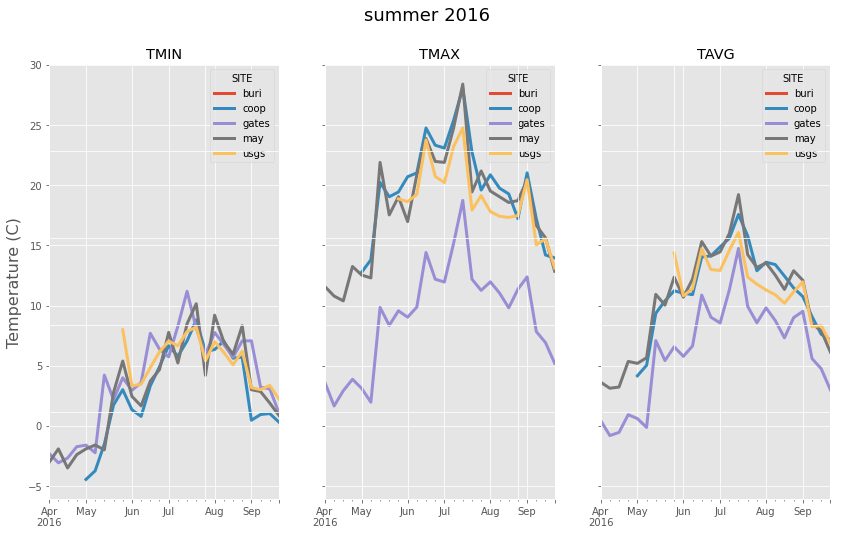

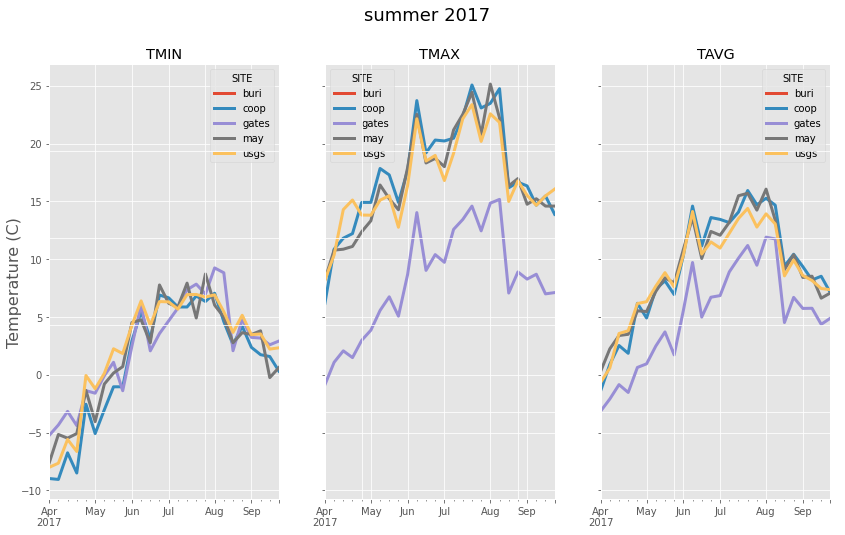

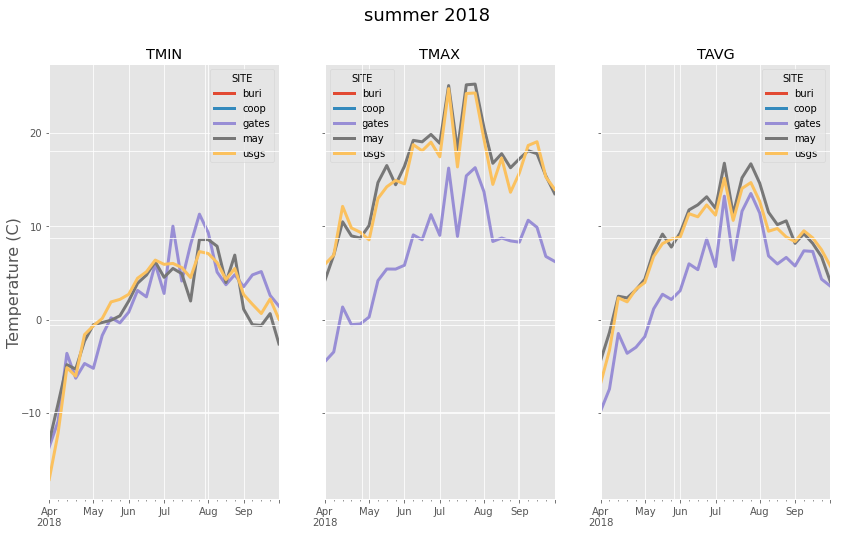

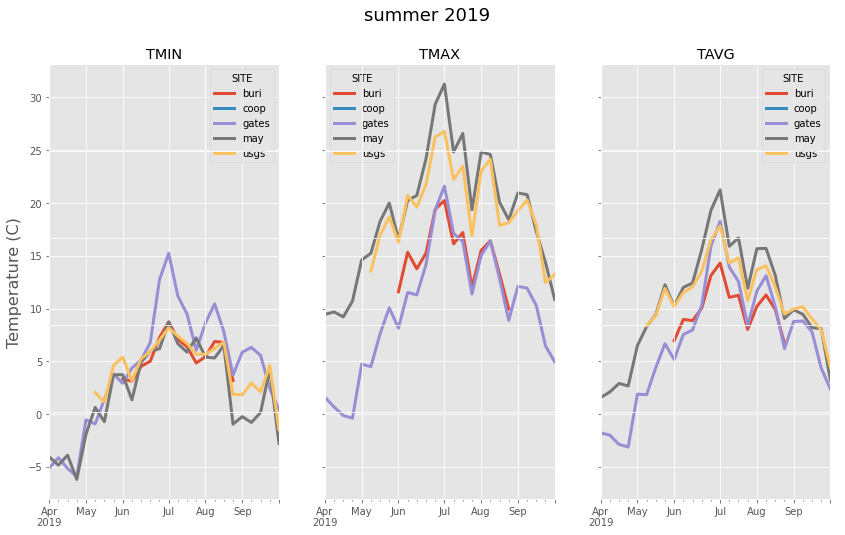

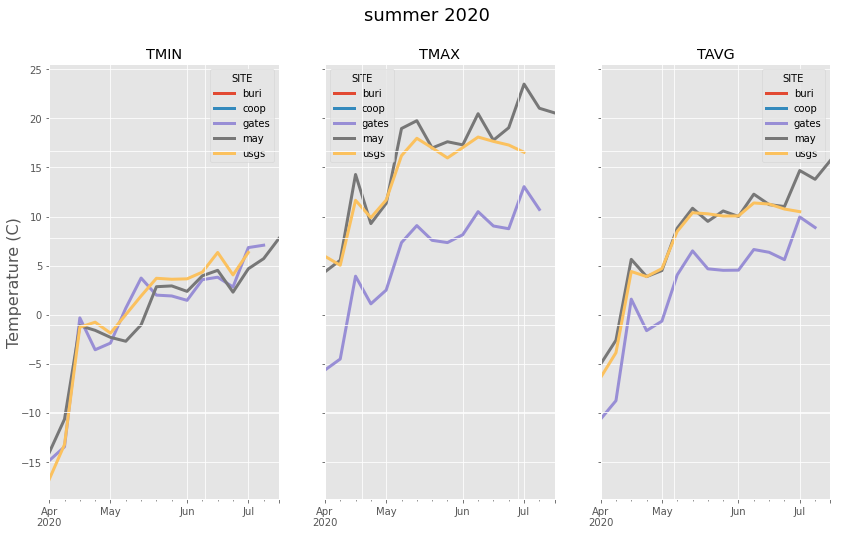

In [44]:
# --- Plot weekly averaged temperature records
# put in index column
ww = AK_ix(ww)
# plot
summer_plots(ww)

#### 3.2 USGS Record Gap-Filling

In [45]:
# --- Re-load Data
meta = pd.read_pickle(os.path.join(format_data,'temperature_meta.pickle'))
dd = pd.read_pickle(os.path.join(format_data,'daily_temperature_data.pickle'))

def temp_scat(x,y,title,labels,legend=False):
    fig,ax = plt.subplots(figsize=(9,9))
    ax.set_title(title)
    # plot data
    ax.scatter(x,y,s=8,color='steelblue')
    # plot 1 to 1 line
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', lw=3,label='1 to 1 line')
    # put r^2 and regression line on plot
    mask = ~np.isnan(x) & ~np.isnan(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
    r2 = r_value**2
    xo = np.linspace(x.min(),x.max(),)
    Yhat = (slope*xo) + intercept # regression y coords
    ax.plot(xo,Yhat,'--',linewidth=3,color='darkorchid',label='OLS line')
    # annotate with r2 and regression equation
    ax.annotate('$r^2$ = {:.2f}'.format(r2),(-40,-25),fontsize=14)
    ax.annotate('y = {0:.2f}(x) + {1:.2f}'.format(slope,intercept),(5,0),fontsize=12)
    # labels
    ax.axis('square')
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])
    if legend:
        ax.legend(loc='upper left')
    # display
    fig.tight_layout()
    plt.show()
    
def gap_ix(df):
    """ Fill in a second index to use in extracting data"""
    seasons = {'summer': [6,7,8,9], 
               'winter_gap': [1,2,3,4,5,10,11,12]} # this can be adjusted based on distribution of values
    months = {num:sea for sea in seasons.keys()
                            for num in seasons[sea]}
    # name winter according to year which it starts
    sea = pd.Series(df.index.month).map(months)
    # put back into dataframe
    seaidx = pd.Index(sea,name='GAP')
    df = df.set_index(seaidx,append=True)
    
    return df

In [46]:
# --- Subset data from other years' winters

# get date range for the usgs gap during winter 2018/2019
start = pd.Timestamp('2018-01-01 00:00:00-0800',tz='US/Alaska')
end = pd.Timestamp('2019-08-01 00:00:00-0800',tz='US/Alaska')
idx=pd.IndexSlice
# grab the usgs TAVG series
period = dd.loc[slice(start,end),idx['usgs','TAVG']] # isolate year with the winter gap
gaps = period.loc[pd.isna(period)].index
print('Missing data are from {} through {}'.format(gaps[0],gaps[-1]))


Missing data are from 2018-10-10 00:00:00-08:00 through 2019-05-08 00:00:00-08:00


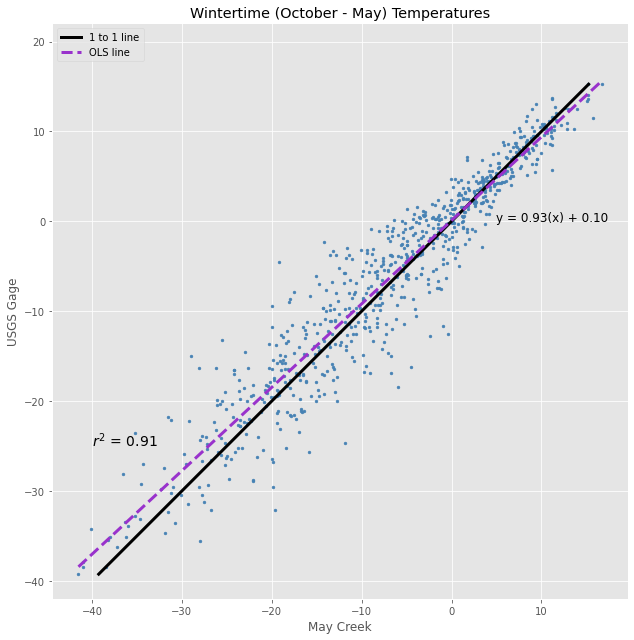

In [47]:
# --- Extract and plot data relationship between stations
dd_new = gap_ix(dd)
# subset winter data for usgs, may sites for TAVG variable
idx = pd.IndexSlice
train = dd_new.loc[idx[:,'winter_gap'],idx[['usgs','may'],'TAVG']].copy()
# drop gap index
train = train.reset_index(level=1,drop=True) # remove gap index
# drop columns level
train.columns = train.columns.droplevel(1) # remove TAVG labels 

x = train['may']
y = train['usgs']
title = ('Wintertime (October - May) Temperatures')
label = ['May Creek','USGS Gage']

temp_scat(x,y,title,label,legend=True)


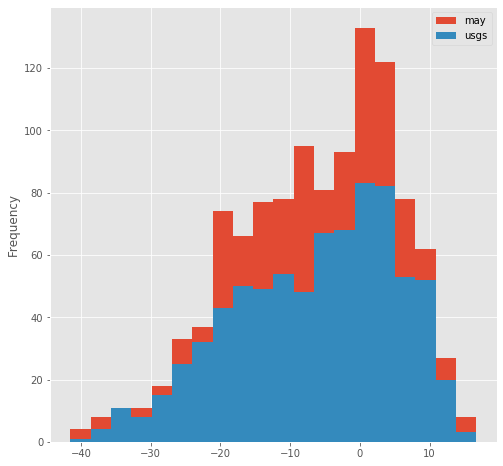

In [26]:
# 1. Histogram 
train.plot(kind='hist',bins=20,figsize=(8,8))
# ... normal enough! 
plt.show()

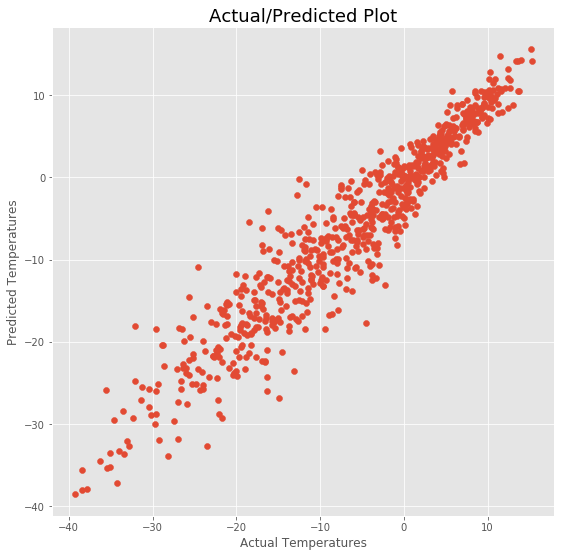

In [27]:
# 2. Residuals plot
x = train['may']
y = train['usgs']
mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
Yhat = (slope*x) + intercept # regression-precicted y coords
res = y - Yhat #  actual - predicted

# --- Actual/Predicted Plot
fig,ax = plt.subplots(figsize=(9,9))
ax.set_title('Actual/Predicted Plot',fontsize=18)
ax.scatter(y,Yhat)
ax.set_xlabel('Actual Temperatures')
ax.set_ylabel('Predicted Temperatures')
plt.show()


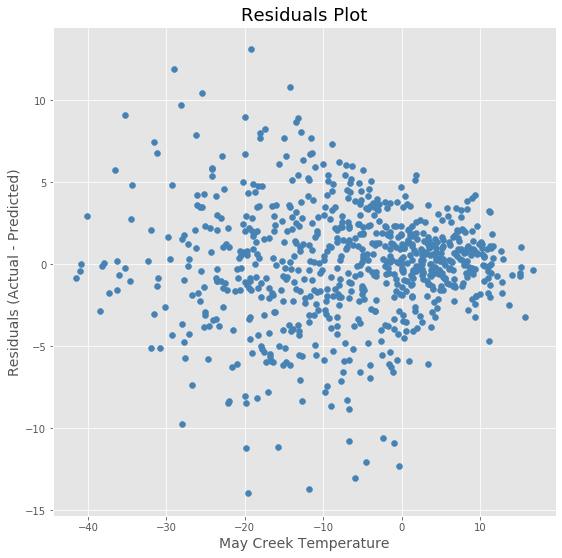

In [28]:
# --- Residuals vs x
fig,ax = plt.subplots(figsize=(9,9))
ax.set_title('Residuals Plot',fontsize=18)
ax.scatter(x,res,color='steelblue')
ax.set_ylabel('Residuals (Actual - Predicted)',fontsize=14)
ax.set_xlabel('May Creek Temperature',fontsize=14)
plt.show()

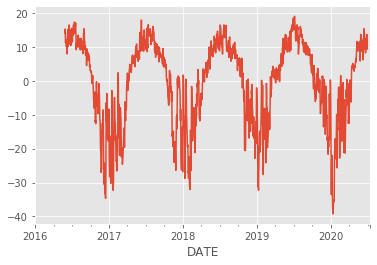

In [32]:
# --- Complete usgs record with adjusted may temps
idx = pd.IndexSlice
dtvg = dd.loc[:,idx[['usgs','gates','buri'],'TAVG']].copy() # new df
#dtvg = dtvg.reset_index(level=1,drop=True) # remove gap index
dtvg.columns = dtvg.columns.droplevel(1) # remove tavg index

# direct assignment fill values
may_vals = train.loc[idx[gaps[0]:gaps[-1]],'may'].copy()
fill = (may_vals *  slope) + intercept # slope, intercept defined in cell above

# swap in values
dtvg.loc[idx[gaps[0]:gaps[-1]],'usgs'] = fill # direct fill

# view complete record
dtvg.loc[:,'usgs'].plot()

# save new record 
dtvg.to_pickle(os.path.join(format_data,'daily_tavg.pickle'))
dtvg.to_csv(os.path.join(format_data,'daily_tavg.csv'))

#### 3.3 Lapse Rate Calculation

In [5]:

# ---- calculate lapse rates for summer
dtvg = pd.read_pickle(os.path.join(format_data,'daily_tavg.pickle'))
meta = pd.read_pickle(os.path.join(format_data,'temperature_meta.pickle'))

# useful functions
def lr_ix(df):
    """ put seasonal index into dataframe for use in splitting data into melt and non-melt seasons"""
    seasons = {'melt': [4,5,6,7,8,9,10], # April - November
               'non-melt': [1,2,3,11,12]}
    months = {num:sea for sea in seasons.keys()
                            for num in seasons[sea]}
    # name winter according to year which it starts
    sea = pd.Series(df.index.month).map(months)
    # put back into dataframe
    seaidx = pd.Index(sea,name='MELT')
    df = df.set_index(seaidx,append=True)
    
    return df

def lr_plot(daily,freq, drop_buri=True,plot=True):
    """ daily is the daily dataframe, freq is the frequency period to
    resample over. Also returns melt dataframe."""
    
    if freq != 'D':
        # resample
        df = daily.resample(freq).mean()
    else:
        df = daily.copy()
    # add melt season index in
    df = lr_ix(df)
    # subset just melt season out, drop index
    idx = pd.IndexSlice
    melt = df.copy()
    melt.loc[idx[:,'non-melt'],:] = np.nan # turn non-melt values to nan
    if drop_buri:
        melt = melt.drop(['buri'],axis=1) # drop buri for now
    
    melt = melt.reset_index(level=1,drop=True) # drop melt index
    # calculate lapse rate (high minus low) C per km
    melt['lapse'] = 1000 * (melt['gates'] - melt['usgs']) / (meta.el['gates'][0] - meta.el['usgs'][0])
    
    if plot:# plot
        plt.close()
        melt.lapse.plot()
    
    return melt

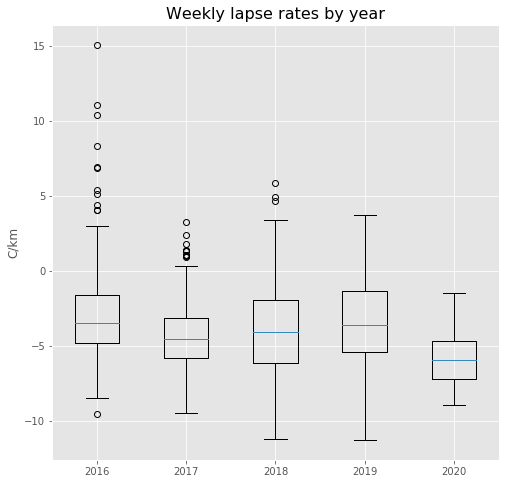

In [8]:
# boxplot by summer season
melt = lr_plot(dtvg,'D',plot=False)
years = [2016,2017,2018,2019,2020]
data = []
fig,ax = plt.subplots(figsize=(8,8))
ax.set_title('Weekly lapse rates by year',fontsize=16)
# put data into list for plotting
for year in years:
    # remove nan rows
    melt = melt.dropna(subset=['lapse'])
    cut = melt[melt.index.year == year]['lapse']
    data.append(np.array(cut)) # just keep lapse values, not index
   
ax.boxplot(data)
ax.set_xticklabels(str(y) for y in years)
ax.set_ylabel('C/km')
plt.show() 
   

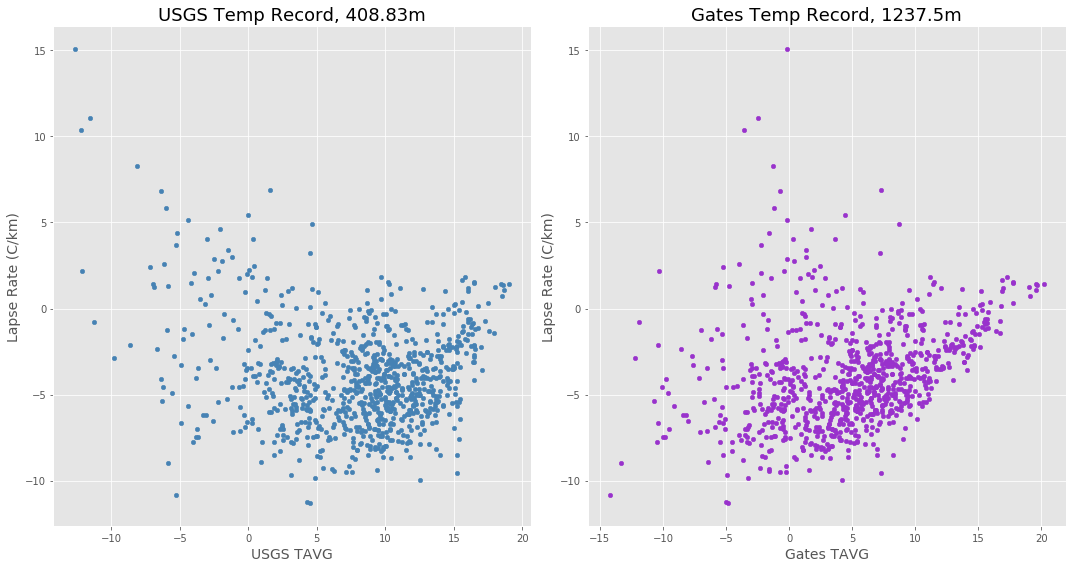

In [9]:
# temps subplots for weekly averaged lapse rates
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,8))
# usgs
ax1.scatter(melt['usgs'],melt['lapse'],color='steelblue',s=20)
ax1.set_title('USGS Temp Record, {}m'.format(meta.el['usgs'][0]),fontsize=18)
ax1.set_ylabel('Lapse Rate (C/km)',fontsize=14)
ax1.set_xlabel('USGS TAVG',fontsize=14)
# gates
ax2.scatter(melt['gates'],melt['lapse'],color='darkorchid',s=20)
ax2.set_title('Gates Temp Record, {}m'.format(meta.el['gates'][0]),fontsize=18)
ax2.set_ylabel('Lapse Rate (C/km)',fontsize=14)
ax2.set_xlabel('Gates TAVG',fontsize=14)
fig.tight_layout()
plt.show()

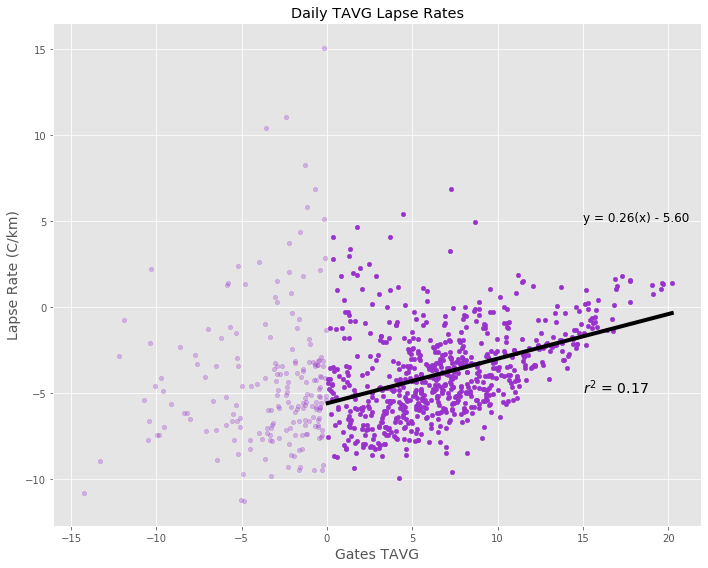

In [10]:
# --- regress LR with just gates temps
above = pd.DataFrame(data={'gates': melt['gates'].loc[melt['gates']>= 0],
                           'lapse': melt['lapse'].loc[melt['gates']>= 0]})
# plot up
fig,ax = plt.subplots(figsize=(10,8))
# data points
x,y = above['gates'],above['lapse']
ax.scatter(x,y,color='darkorchid',s=20)
ax.scatter(melt['gates'].loc[melt['gates']< 0], melt['lapse'].loc[melt['gates'] < 0],
           color='darkorchid',s=20, alpha=0.3)
# regression
mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
r2 = r_value**2
xo = np.linspace(x.min(),x.max(),)
Yhat = (slope*xo) + intercept # regression y coords
ax.plot(xo,Yhat,'-',linewidth=4,color='k')
# annotate with r2 and regression equation
ax.annotate('$r^2$ = {:.2f}'.format(r2),(15,-5),fontsize=14)
ax.annotate('y = {0:.2f}(x) - {1:.2f}'.format(slope,-intercept),(15,5),fontsize=12)
# labels
ax.set_title('Daily TAVG Lapse Rates')
ax.set_ylabel('Lapse Rate (C/km)',fontsize=14)
ax.set_xlabel('Gates TAVG',fontsize=14)
fig.tight_layout()
plt.show()

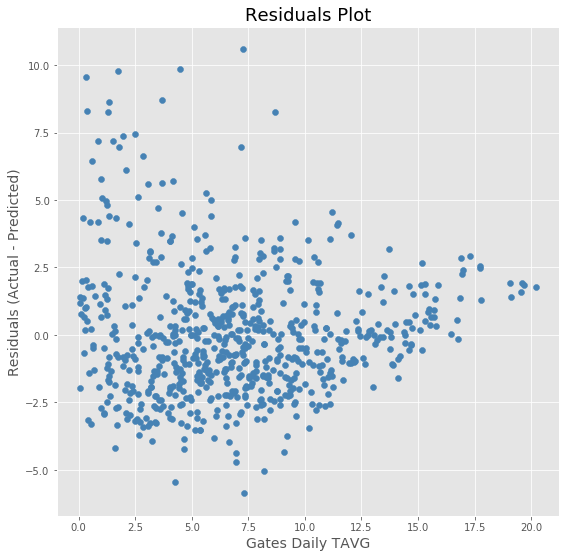

In [11]:
# calculate new Yhat with all x 
Yxhat = (slope*x) + intercept # regression-precicted y coords
res = y - Yxhat #  actual - predicted

# --- Residuals Plot
fig,ax = plt.subplots(figsize=(9,9))
ax.set_title('Residuals Plot',fontsize=18)
ax.scatter(x,res,color='steelblue')
ax.set_ylabel('Residuals (Actual - Predicted)',fontsize=14)
ax.set_xlabel('Gates Daily TAVG',fontsize=14)
plt.show()

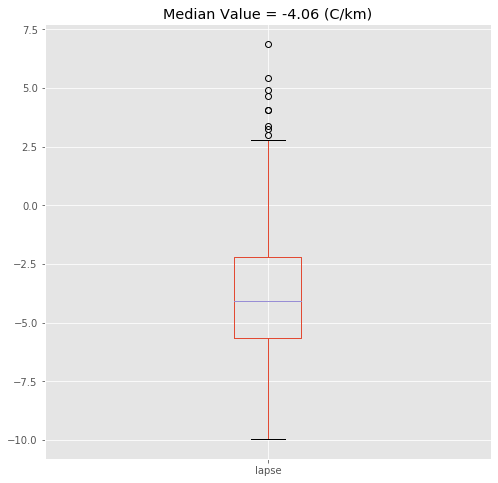

In [12]:
# boxplot
plt.figure(figsize=(8,8))
above['lapse'].plot(kind='box',title='Median Value = {0:.2f} (C/km)'.format(np.nanmedian(above['lapse'])))
plt.show()

#### 3.4 Example Melt Model

In [13]:
lr = -4.06 # c/km - derived from LR_Exploration median value

In [14]:
# --- stake variables
kl_el = 790 # meters
kl_spring = pd.Timestamp('2019-06-07',tz='US/Alaska') # date of spring visit
kl_fall = pd.Timestamp('2019-08-22',tz='US/Alaska') # date of fall visit
kl_swe = 5.28 # m w.e. ice ablated between visits. 
usgs_el = 409 # meters,  appr. elevation of usgs gage station

# ---load usgs data
dtvg = pd.read_pickle(os.path.join(format_data,'daily_tavg.pickle')) # read in temperature data w/ filled usgs record
dtvg.columns # just tavg for usgs, buri, and gates
# identify dates of shoulder season .... can edit these dates as appropriate
start = pd.Timestamp('2019-03-01',tz='US/Alaska')
end = pd.Timestamp('2019-11-01',tz='US/Alaska')

In [15]:
# --- construct new dataframe for stake variables
kl = pd.DataFrame(index=pd.date_range(start,end,freq='D'))
kl['usgs'] = dtvg.loc[slice(start,end),'usgs'] # grab usgs temperatures
site_diff = (kl_el - usgs_el) / 1000 # convert to km
kl['stake'] = kl.usgs + (lr * site_diff) # calculate synthetic stake temps

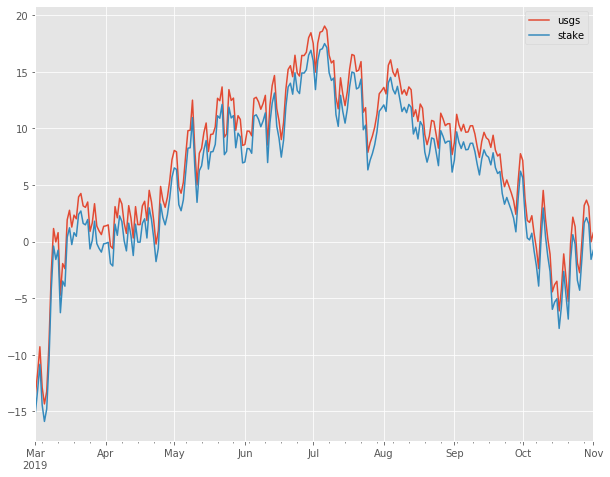

In [16]:
plt.figure(figsize=(10,8))
kl.usgs.plot(label='usgs')
kl.stake.plot(label='stake')
plt.legend()
plt.show()

In [17]:
# --- fit melt rate parameter (a = dd*ki)
dddf = kl.loc[slice(kl_spring,kl_fall),'stake'] # new dataframe for just days between visits
dd = dddf.loc[dddf > 0].sum() # sum degree days
ki = (kl_swe * 1000) / dd   # units mm / d*C
# print out value
print( 'Degree day ice factor for Kenn Low stake ({0} m) for summer 2019 is {1:.2f} mm/d*C'
      .format(kl_el,ki))

Degree day ice factor for Kenn Low stake (790 m) for summer 2019 is 5.66 mm/d*C


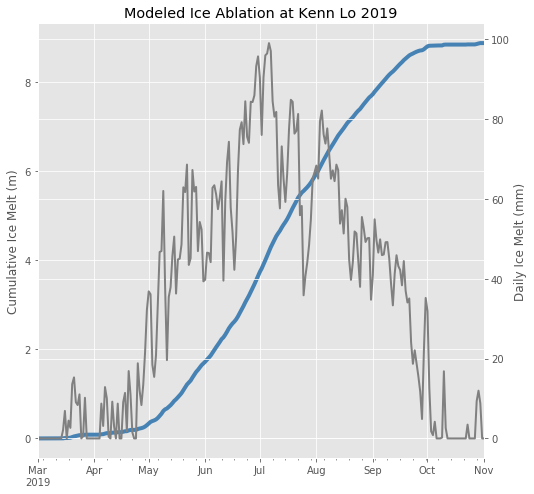

In [18]:
# ---- Modeled ice ablation records
kl['dd'] = kl['stake'].where(kl['stake'] > 0, 0) # columns of individual degree days
kl['cumdd'] = kl['dd'].cumsum() #  cumulative DD column
kl['cumabl'] = kl['cumdd'].multiply(ki / 1000) # cumulative ablation column (meters)
kl['abl'] = kl['cumabl'].diff().multiply(1000) # daily ice ablation in mm

# --- Visualize modeled melt
fig,ax = plt.subplots(figsize=(8,8))
ax.set_title('Modeled Ice Ablation at Kenn Lo 2019')
kl.cumabl.plot(ax=ax,linewidth=4,color='steelblue')
ax.set_ylabel('Cumulative Ice Melt (m)')
# plot daily melt
ax2 = ax.twinx()
ax2.set_ylabel('Daily Ice Melt (mm)')
kl.abl.plot(ax=ax2,linewidth=2,color='gray')
plt.show()

In [19]:
# ---- Modeled + empirical ice ablation (For when DDF has some error...)
pre_visit = kl.loc[(kl_spring - pd.Timedelta(1,'D')),'cumabl'] # m of modeled ice melt before spring visit, not counting visit day
post_visit = kl.loc[end,'cumabl'] - kl.loc[kl_fall,'cumabl']# m of modeled ice melt post visit, not counting visit day
full_season = pre_visit + kl_swe + post_visit # add in empirical ice melt b/w visits
print('Full Season Melt for {0} during {1} is {2:.1f} m w.e.'.format('Kenn Lo',kl_spring.year,full_season))


Full Season Melt for Kenn Lo during 2019 is 8.9 m w.e.


### 4. Next Steps